## Model infrastructure

We're going to predict the KPI data using the spatial data we've collected and aggregated into H3.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import sklearn as sk
import matplotlib.pyplot as plt

## 1 Preparing the data

In [14]:
#read in the BCN pilot 1 data from the geojson
# Read the GeoJSON file
gdf = gpd.read_file("../data/Location/reallocate_all_pilots.geojson")

# Filter for Barcelona Pilot1
barcelona = gdf[(gdf["pilot"] == "Pilot1") & (gdf["city"] == "Barcelona")]

# Combine multiple polygons if necessary
barcelona_union = barcelona.dissolve(by="pilot")

In [15]:
#Read in the model-ready H3 data
h3 = gpd.read_parquet("../data/processed/barcelona_h3_res10_model_features.parquet")

<Axes: >

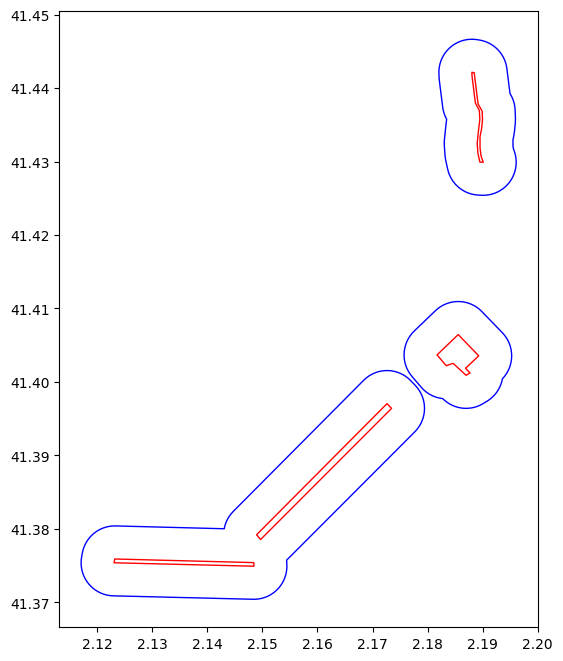

In [16]:
# Reproject to UTM zone that covers Barcelona, to work in meters
barcelona_utm = barcelona_union.to_crs(epsg=25831)  # ETRS89 / UTM zone 31N

# Buffer by 500 meters (change as appropriate)
barcelona_buffer = barcelona_utm.buffer(500)

# Convert back to WGS84
barcelona_buffer_wgs = gpd.GeoDataFrame(geometry=barcelona_buffer, crs="EPSG:25831").to_crs("EPSG:4326")


f, ax = plt.subplots(figsize=(8,8))
barcelona_buffer_wgs.plot(edgecolor="blue", facecolor="none", figsize=(6,6), ax=ax)
barcelona_union.plot(edgecolor="red", facecolor="none", ax=ax)


<Axes: >

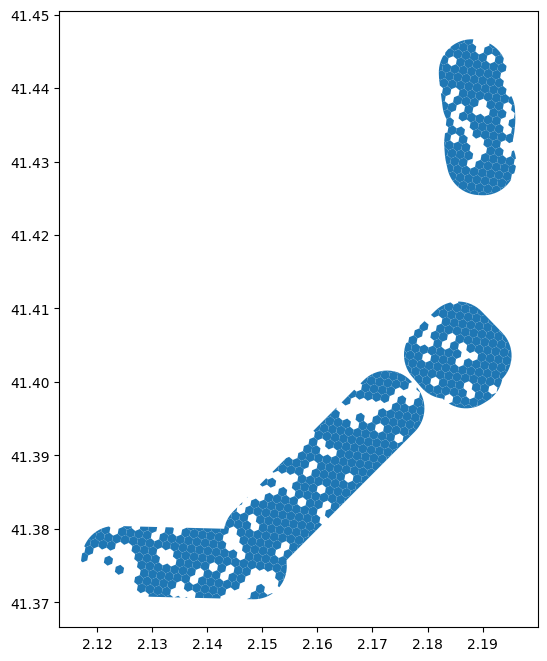

In [17]:
h3 = h3.to_crs("EPSG:4326")

# 6️⃣ Clip H3 polygons to the buffered area
h3_clipped = gpd.clip(h3, barcelona_buffer_wgs)

# 7️⃣ Optional: reproject back to EPSG:4326 
#h3_clipped = h3_clipped.to_crs("EPSG:4326")

#visualize
h3_clipped.plot(figsize=(8,8))

In [18]:
import json
json_path = "../data/Dummy/pilot_kpis.json" ## This could be merged with the pilots json from earlier
with open(json_path, "r") as f:
    pilot_data = json.load(f)

# Flatten the nested structure
rows = []
for pilot, kpis in pilot_data.items():
    for kpi in kpis:
        rows.append({
            "pilot": pilot,
            **kpi  # expands all KPI keys
        })

df_json = pd.DataFrame(rows)
bcn_1 = df_json[df_json["pilot"] == "Barcelona_1"]
bcn_1

,pilot,name,theme,kpi_theme_id,unit,baseline_value,post_value
0,Barcelona_1,Number of participants engaged,Engagement,1,counts,57.45,143.59
1,Barcelona_1,reported risk factors affecting perceived road...,road safety,2,counts,93.20,97.83


Here we have the baseline and post-intervention results. However, we need a dependent variable by which to meaure the KPI. In this instance, we can calculate the % change. However, this does not necessarily make KPIs comparable. If one KPI is measured in %, and another in counts, these will not be directly comparable by % change or elsewise.

This is something to consider for later...

In [19]:
bcn_1["pct_change"] = (bcn_1["post_value"] - bcn_1["baseline_value"]) / bcn_1["baseline_value"] * 100
bcn_1

/var/folders/v1/1n4sj6l570n0zlr6q42nxf9c0000gn/T/ipykernel_85429/3527837267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcn_1["pct_change"] = (bcn_1["post_value"] - bcn_1["baseline_value"]) / bcn_1["baseline_value"] * 100


,pilot,name,theme,kpi_theme_id,unit,baseline_value,post_value,pct_change
0,Barcelona_1,Number of participants engaged,Engagement,1,counts,57.45,143.59,149.939077
1,Barcelona_1,reported risk factors affecting perceived road...,road safety,2,counts,93.20,97.83,4.967811


In [11]:
h3_clipped.head(3)

,h3_id,geometry,cluster_0_golf,cluster_1_military_religious_transportation,cluster_2_developed_horticulture_residential,cluster_3_park_pedestrian_recreation,cluster_0_salon_shop_store,cluster_1_utility_rental_service,cluster_2_care_animal_school,cluster_3_place_station_sport,cluster_0_entertainment_medical_religious,cluster_1_military_service_transportation,cluster_2_civic_residential,cluster_3_outbuilding,mean_ndvi
696,8a394461c897fff,"POLYGON ((2.13626 41.37073, 2.13645 41.37062, ...",0.0,0.000000,9.617766,22.072828,5.0,7.0,3.0,5.0,3.818376,22.958765,68.605817,0.0,0.068507
1244,8a394461c8d7fff,"POLYGON ((2.13944 41.37111, 2.14028 41.37137, ...",0.0,39.821694,0.000000,38.891172,4.0,2.0,1.0,1.0,0.000000,0.000000,52.694846,0.0,0.075381
3146,8a394461c88ffff,"POLYGON ((2.13794 41.37126, 2.13877 41.37152, ...",0.0,0.000000,0.000000,11.959096,6.0,8.0,0.0,6.0,3.751929,0.000000,66.772204,0.0,0.099344


## Now the data is clipped, we can proceed with modelling steps...

#### One thing we should be wary of

Is that the merged data is made up of 2 or 3 different data types. That being continuous, finite range (0-1).

Within our dataset, we have:

* **POIs** - aggregated dummy data - numeric, discrete counts
* **% cover vars** - continuous, bounded (0-1?, 0-100?)
* **sociodem?** - these could be a mix of raw counts and % and dummy vars

The scales and distributions differ, so naively feeding these variables into the model means that the raw counts will dominate the variance.

#### Therefore we need to use a modelling pipeline that handles each data type appropriately.

---

#### % cover variables
should all be scaled to 0-1

#### count variables (POIs)
These are right skewed and have a large dispersion. There are a number of options to deal with this:
* Log-transform
* Standardize
* Use a model that is expicitly designed for counts.

#### This is because:

Most spatial models assume continuous predictors, roughly similar variance and no significant differences within the skew. **GWR** is especially sensitive to variable units. If they're on different scales, this can break the selection of bandwidths and affect interpretability. So, always scale predictors before GWS.

#### If we want to cluster:

All variables must be on a comparable scale with similar distributions.

> Compositional constraints - Where the percentages of a particular topic would add up to 100%, so by one sector increasing, another must decrease. I don't think this is the case here.

> Right skewed - City centers (few hexes) may have more POIs than 90% of hexes.

> Zero inflated - More 0's than expected (99% of hexes - 0 stadiums, 1% hexes - stadium)

> Overdispersion - real world POI data is heavily varied. Poisson model assumes mean == variance.


In [20]:
h3_clipped.head(3)

,h3_id,geometry,landuse_golf,landuse_military_religious_transportation,landuse_developed_horticulture_residential,landuse_park_pedestrian_recreation,pois_salon_shop_store,pois_rental_rental service_service,pois_organization_school_animal,pois_park_sport_station,buildings_entertainment_medical_religious,buildings_military_service_transportation,buildings_civic_residential,buildings_outbuilding,mean_ndvi
1367,8a394461ca5ffff,"POLYGON ((2.15282 41.3722, 2.15299 41.37288, 2...",0.0,0.000000,1446.288770,9.518377,0.0,1.0,0.0,5.0,12.923211,0.0,0.767747,0.0,0.119115
1536,8a394461ca4ffff,"POLYGON ((2.15382 41.37314, 2.15399 41.37382, ...",0.0,2.986982,1446.284203,0.000000,2.0,3.0,1.0,11.0,14.499769,0.0,6.500694,0.0,0.099704
1830,8a394461ca47fff,"POLYGON ((2.15332 41.37424, 2.15399 41.37382, ...",0.0,0.000000,357.210756,20.458027,0.0,0.0,0.0,1.0,10.925429,0.0,0.000000,0.0,-0.012185


In [29]:
h3_clipped.explore()

In [22]:
import ipywidgets as widgets
from IPython.display import display, HTML

# ---- Define your tasks ----
tasks = [
    "as of 2025-11-19, the landuse data is displaying some erroneous values >> 100%",
]

# ---- Create widget UI ----
checkboxes = []
items_html = []

for task in tasks:
    cb = widgets.Checkbox(description="", indent=False)
    label = widgets.HTML(f"<span style='font-size: 15px;'>{task}</span>")
    checkboxes.append((cb, label))

# ---- Strikethrough update ----
def update(change):
    for cb, label in checkboxes:
        if cb.value:
            label.value = f"<span style='text-decoration: line-through; color: gray;'>{label.value.split('>')[1].split('<')[0]}</span>"
        else:
            text = label.value.replace("<span style='text-decoration: line-through; color: gray;'>", "").replace("</span>", "")
            label.value = f"<span style='font-size: 15px;'>{text}</span>"

for cb, _ in checkboxes:
    cb.observe(update, "value")

# ---- Display clean layout ----
container = widgets.VBox([
    widgets.HBox([cb, label]) for cb, label in checkboxes
])
display(container)


## So now we have a problem...

Great, we have spatial variables for each hexagon. We can change the resolution of the hexagon, we can acquire this data for different areas by entering a bounding box. Fantastic... But there's one fundamental issue.

#### We can't run a regression on a singe dependent variable

i.e. we have one value for the KPI, that is non-spatial. This means we **cannot** predict this variable based on *any* factors. So what can we do with this data?

### Provide spatial context.

We can cluster attributes of the hexagons to provide a descriptive cluster of the pilot site. i.e. is the pilot site dominated by a given landuse/building/poi cluster? is it green?


## Standard regression

In [ ]:
#Read in the non-spatial dummy data
CoCreation = pd.read_json("../data/Dummy/Barcelona_Pilot_1_Synthetic_data/Barcelona_BCN_P1_KPI_01_CoCreationParticipants.json") # What is the KPI here? number of participants?
Safety = pd.read_json("../data/Dummy/Barcelona_Pilot_1_Synthetic_data/Barcelona_BCN_P1_KPI_02_SafetyPerception.json")
Satisfaction = pd.read_json("../data/Dummy/Barcelona_Pilot_1_Synthetic_data/Barcelona_BCN_P1_KPI_03_SatisfactionSharedSpace.json")


In [76]:
Safety.head(3)

,kpi_id,city,pilot_number,umi_category,respondent_id,date,gender,age,feels_safe,source_type,feels_safe_meaning
0,BCN_P1_KPI_02,Barcelona,1,Accidents and Injuries,S0001,2024-12-08,Woman,14,4,synthetic,Safe
1,BCN_P1_KPI_02,Barcelona,1,Accidents and Injuries,S0002,2024-12-05,Woman,17,5,synthetic,Very Safe
2,BCN_P1_KPI_02,Barcelona,1,Accidents and Injuries,S0003,2024-12-11,Woman,17,4,synthetic,Safe


In [40]:
Satisfaction.columns

Index(['kpi_id', 'city', 'pilot_number', 'umi_category', 'respondent_id',
       'date', 'gender', 'age', 'satisfaction_score', 'source_type',
       'satisfaction_meaning'],
      dtype='object')

Satisfaction score, and feels_safe, will be our dependent variables here. 

#### Because we have an ordinal dependent variable (Ranked 1-5) we can't use ordinary least squares. Instead we can use Ordinal Logistic regression, which also accepts categorical and numeric data.

#### Satisfaction model

In [72]:
Satisfaction.head(3)

,kpi_id,city,pilot_number,umi_category,respondent_id,date,gender,age,satisfaction_score,source_type,satisfaction_meaning
0,BCN_P1_KPI_03,Barcelona,1,Space Reallocation,S0001,2024-12-12,Woman,14,4,synthetic,Satisfied
1,BCN_P1_KPI_03,Barcelona,1,Space Reallocation,S0002,2024-12-09,Woman,17,4,synthetic,Satisfied
2,BCN_P1_KPI_03,Barcelona,1,Space Reallocation,S0003,2024-12-10,Woman,17,3,synthetic,Neutral


In [70]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# 1. Drop columns not used
df = Satisfaction.drop(columns=["kpi_id", "city", "pilot_number", "umi_category", "respondent_id", "satisfaction_meaning", "date", "source_type"])

# 2. Encode categorical
df_encoded = pd.get_dummies(df, columns=["gender"],drop_first=True)

y = df_encoded["satisfaction_score"].astype(int)
X = df_encoded.drop(columns=["satisfaction_score"])
# Convert boolean columns to integers
X = X.astype(int)
# Drop any constant column explicitly
X = X.loc[:, X.nunique() > 1]




In [71]:

model = OrderedModel(y, X, distr='logit')
res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.023323
         Iterations: 37
         Function evaluations: 40
         Gradient evaluations: 40
                             OrderedModel Results                             
Dep. Variable:     satisfaction_score   Log-Likelihood:                -824.80
Model:                   OrderedModel   AIC:                             1664.
Method:            Maximum Likelihood   BIC:                             1696.
Date:                Thu, 27 Nov 2025                                         
Time:                        18:08:21                                         
No. Observations:                 806                                         
Df Residuals:                     799                                         
Df Model:                           3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

#### Safety model

In [75]:
# 1. Drop columns not used
df = Safety.drop(columns=['kpi_id', 'city', 'pilot_number', 'umi_category', 'respondent_id',
       'date', 'source_type',
       'feels_safe_meaning'])

# 2. Encode categorical
df_encoded = pd.get_dummies(df, columns=["gender"],drop_first=True)

y = df_encoded["feels_safe"].astype(int)
X = df_encoded.drop(columns=["feels_safe"])
# Convert boolean columns to integers
X = X.astype(int)
# Drop any constant column explicitly
X = X.loc[:, X.nunique() > 1]

model = OrderedModel(y, X, distr='logit')
res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.578680
         Iterations: 28
         Function evaluations: 31
         Gradient evaluations: 31
                             OrderedModel Results                             
Dep. Variable:             feels_safe   Log-Likelihood:                -1272.4
Model:                   OrderedModel   AIC:                             2559.
Method:            Maximum Likelihood   BIC:                             2592.
Date:                Thu, 27 Nov 2025                                         
Time:                        18:29:28                                         
No. Observations:                 806                                         
Df Residuals:                     799                                         
Df Model:                           3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

## SHAP

In [79]:
#create random values and assign these to y
h3_clipped['y'] = np.random.randint(0, 100, size=len(h3_clipped))

In [80]:
h3_clipped.head(3)

,h3_id,geometry,landuse_golf,landuse_military_religious_transportation,landuse_developed_horticulture_residential,landuse_park_pedestrian_recreation,pois_salon_shop_store,pois_rental_rental service_service,pois_organization_school_animal,pois_park_sport_station,buildings_entertainment_medical_religious,buildings_military_service_transportation,buildings_civic_residential,buildings_outbuilding,mean_ndvi,y
1367,8a394461ca5ffff,"POLYGON ((2.15282 41.3722, 2.15299 41.37288, 2...",0.0,0.000000,1446.288770,9.518377,0.0,1.0,0.0,5.0,12.923211,0.0,0.767747,0.0,0.119115,76
1536,8a394461ca4ffff,"POLYGON ((2.15382 41.37314, 2.15399 41.37382, ...",0.0,2.986982,1446.284203,0.000000,2.0,3.0,1.0,11.0,14.499769,0.0,6.500694,0.0,0.099704,96
1830,8a394461ca47fff,"POLYGON ((2.15332 41.37424, 2.15399 41.37382, ...",0.0,0.000000,357.210756,20.458027,0.0,0.0,0.0,1.0,10.925429,0.0,0.000000,0.0,-0.012185,4


### Defining x and y

In [83]:
import seaborn as sns
#Let's get our X and y for the regression
y = h3_clipped["y"].astype(int)
X = h3_clipped.drop(columns=["y","h3_id","geometry"])


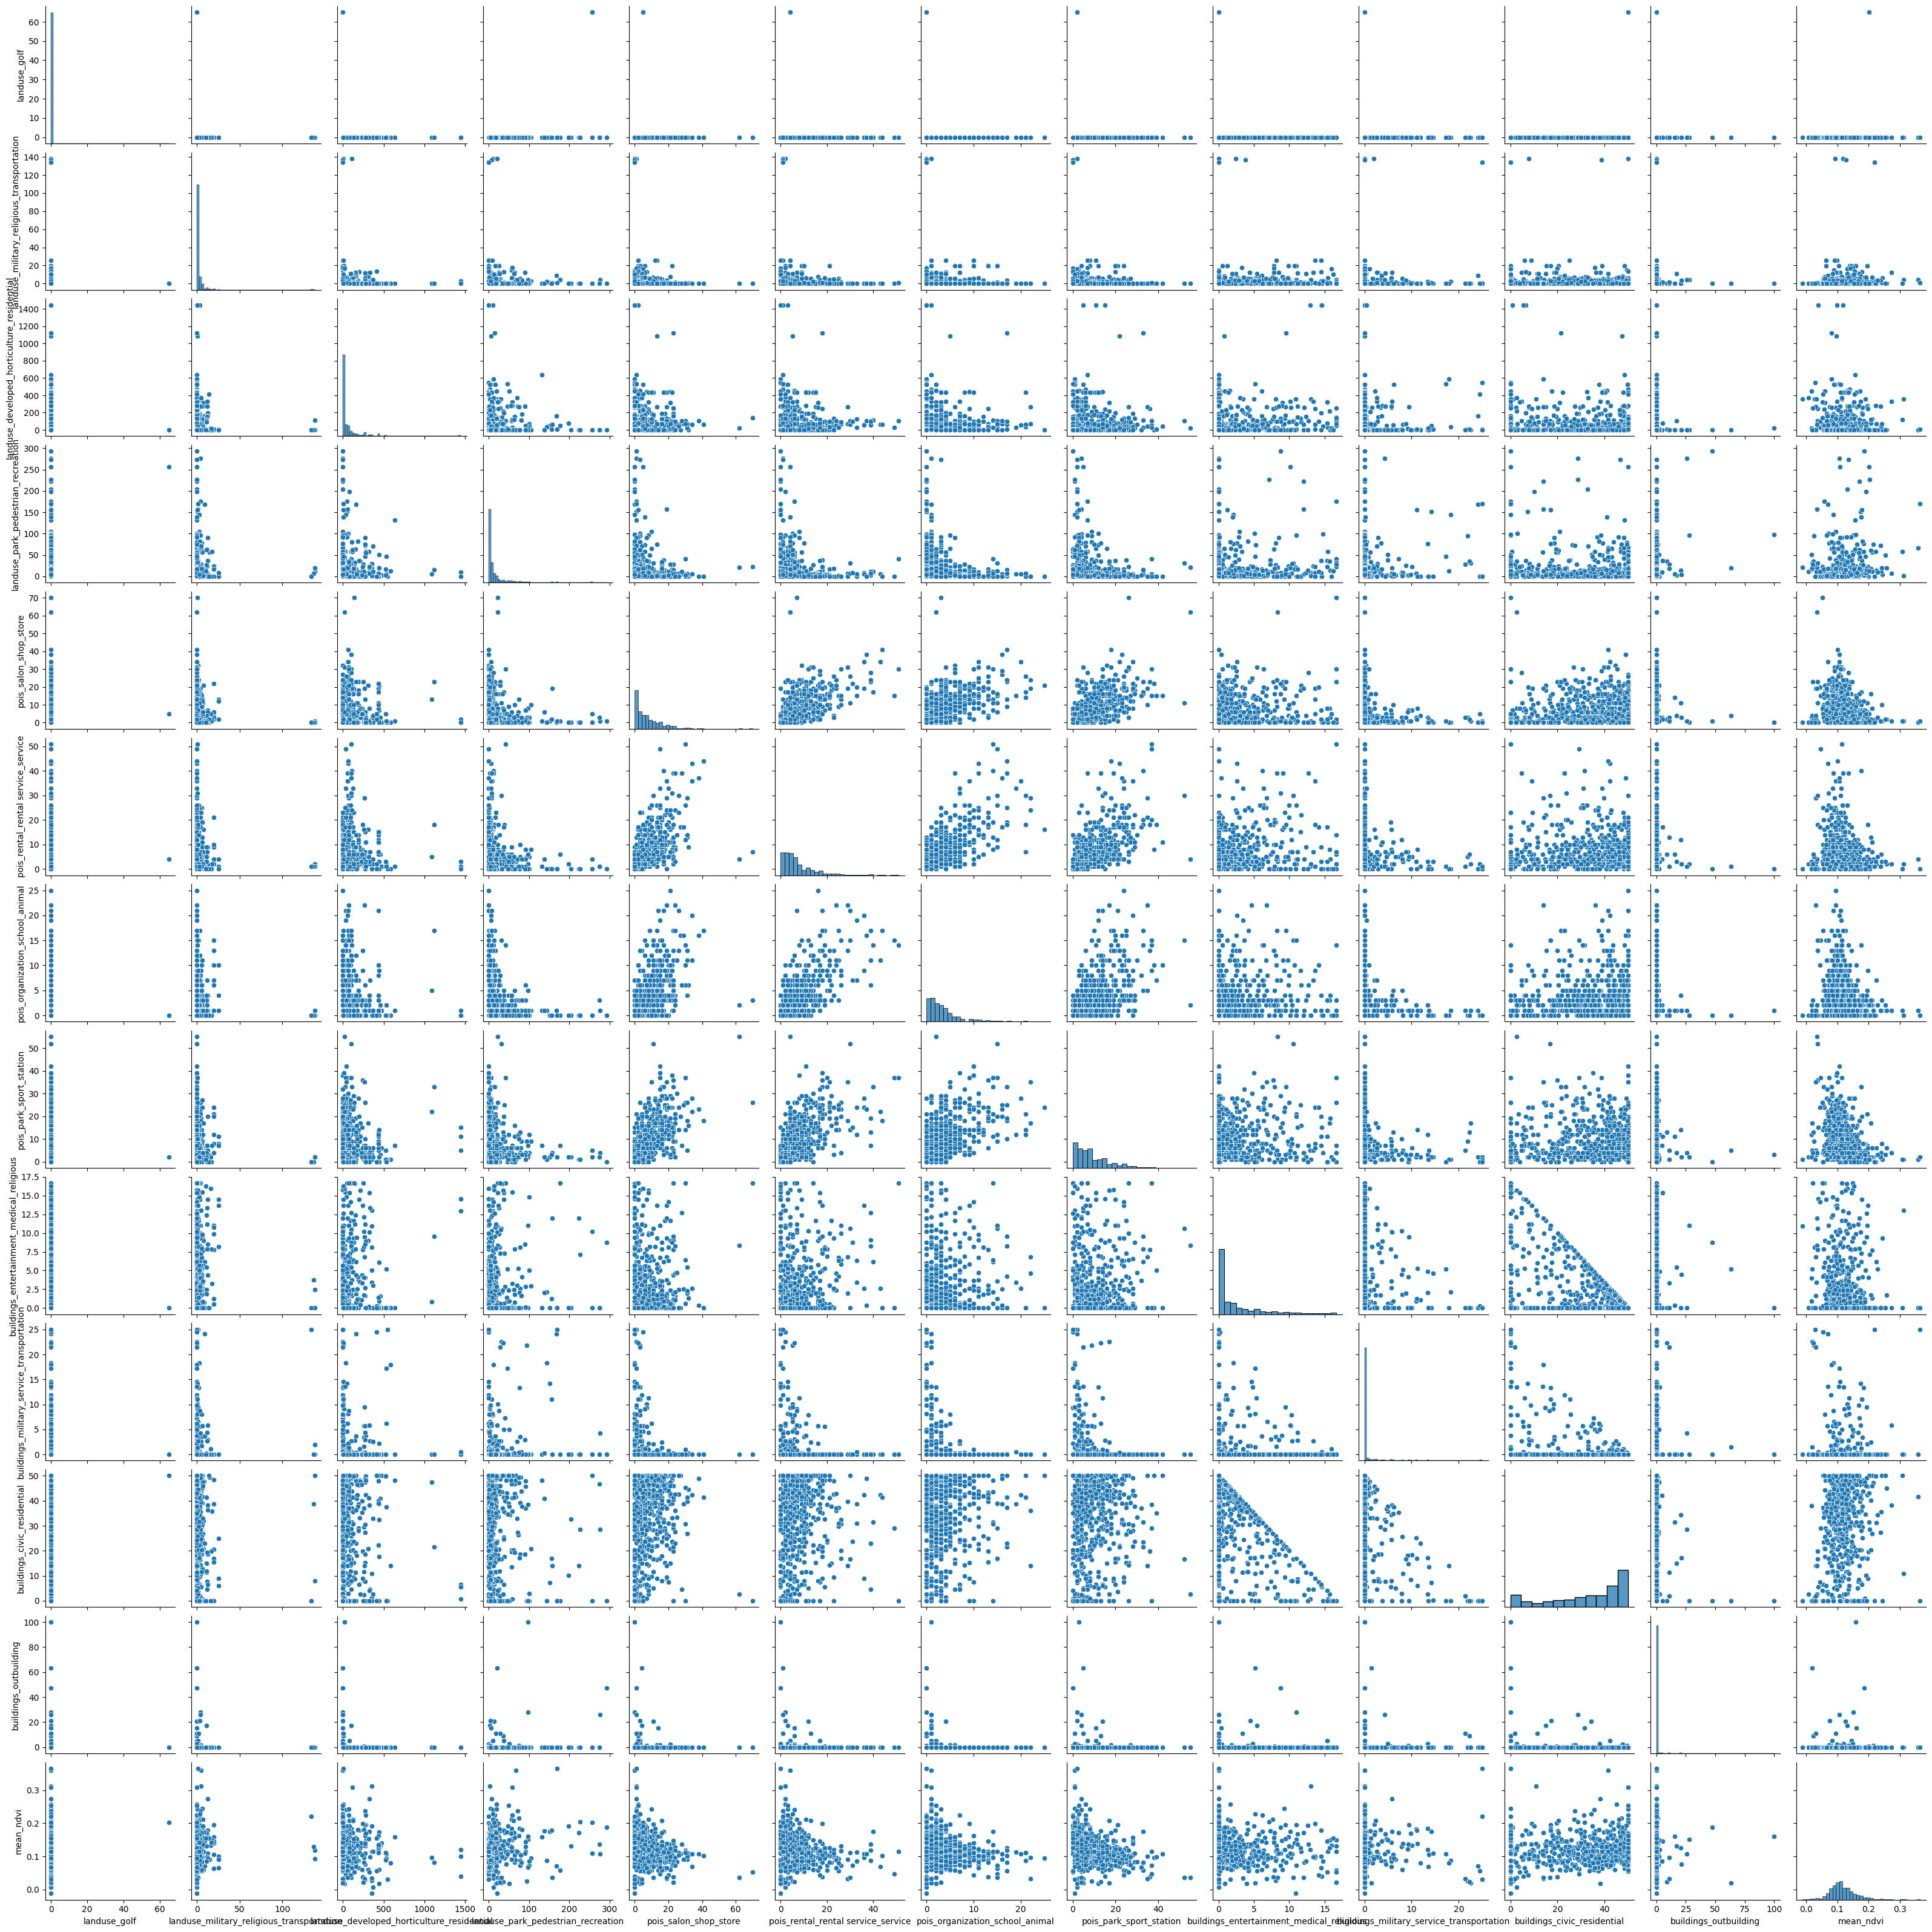

In [84]:
sns.pairplot(X)

## (M)GWR

In [12]:
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

In [85]:
 h3_clipped['geometry']

1367    POLYGON ((2.15282 41.3722, 2.15299 41.37288, 2...
1536    POLYGON ((2.15382 41.37314, 2.15399 41.37382, ...
1830    POLYGON ((2.15332 41.37424, 2.15399 41.37382, ...
1194    POLYGON ((2.15399 41.37382, 2.15332 41.37424, ...
3083    POLYGON ((2.15283 41.37534, 2.15349 41.37492, ...
                              ...                        
2944    POLYGON ((2.18584 41.44597, 2.18567 41.44529, ...
1055    POLYGON ((2.18668 41.44624, 2.18734 41.44582, ...
2922    POLYGON ((2.18818 41.44609, 2.18734 41.44582, ...
1195    POLYGON ((2.18668 41.44624, 2.18584 41.44597, ...
410     POLYGON ((2.19186 41.44536, 2.19119 41.44578, ...
Name: geometry, Length: 645, dtype: geometry

In [92]:
h3_clipped = h3_clipped.to_crs(epsg=32631)
# If geometry is polygons, get centroids
h3_clipped["centroid"] = h3_clipped.geometry.centroid
# Extract X,Y coordinates
coords = np.array(list(zip(h3_clipped.centroid.x, h3_clipped.centroid.y)))


In [96]:
#Prepare Georgia dataset inputs
g_y = y.values.reshape((-1,1))
g_X = X.values

g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0) #standardize independent variables

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0) #standardize dependent variable

In [99]:
duplicated = h3_clipped.centroid.duplicated().sum()
duplicated


np.int64(0)

In [102]:
#Calibrate GWR model

mgwr_selector = Sel_BW(coords, g_y, g_X, multi=True)
mgwr_bws = mgwr_selector.search()   # This just runs the search; not used as input

mgwr_model = MGWR(coords, g_y, g_X, selector=mgwr_selector)
mgwr_results = mgwr_model.fit()

print(mgwr_results.summary())


/Users/jamesmurphy/Documents/GitHub/reallocate_AI/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=9.03747e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/jamesmurphy/Documents/GitHub/reallocate_AI/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.46542e-20): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/jamesmurphy/Documents/GitHub/reallocate_AI/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.66973e-20): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/jamesmurphy/Documents/GitHub/reallocate_AI/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.37007e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/jamesmurphy/Documents/GitHub/

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Model type                                                         Gaussian
Number of observations:                                                 645
Number of covariates:                                                    14

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            636.470
Log-likelihood:                                                    -910.922
AIC:                                                               1849.843
AICc:                                                              1852.607
BIC:                                                              -3445.627
R2:                                                                   0.013
Adj. R2:                                                             -0.007

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------